# Task 3: Customer Segmentation / Clustering

Task was to perform Customer Segmentation using Clustering Techniques, such that we use all the given .csv file including `Transactions.csv`, `Products.csv`, and obviously `Customers.csv`

### Data Pre-processing



Importing all the Dependencies here:

In [167]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

Reading all the given .csv file using pandas `.read_csv` function

In [168]:
customers = pd.read_csv("/content/Customers.csv")
products = pd.read_csv("/content/Products.csv")
transactions = pd.read_csv("/content/Transactions.csv")

#### Feature Engineering

> Here, we have imported code to construct some features, that may help to cluster our. The code was imported from Task 2's Feature Engineering Section



In [169]:
transactions_products = pd.merge(transactions, products, on='ProductID', how='inner')

merged_data = pd.merge(transactions_products, customers, on='CustomerID', how='inner')

merged_data.dropna(inplace=True)

category_counts = merged_data.groupby(['CustomerID', 'Category'], as_index=False)['Quantity'].sum()
category_ranks = category_counts.sort_values(['CustomerID', 'Quantity'], ascending=[True, False])
most_bought_category = category_ranks.groupby('CustomerID').nth(0).reset_index()
second_most_bought_category = category_ranks.groupby('CustomerID').nth(1).reset_index()

product_counts = merged_data.groupby(['CustomerID', 'ProductName'], as_index=False)['Quantity'].sum()
product_ranks = product_counts.sort_values(['CustomerID', 'Quantity'], ascending=[True, False])
most_bought_product = product_ranks.groupby('CustomerID').nth(0).reset_index()
second_most_bought_product = product_ranks.groupby('CustomerID').nth(1).reset_index()

customer_transactions = merged_data.groupby('CustomerID', as_index=False).agg(
    total_transactions=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean')
)

most_bought_category = most_bought_category.rename(columns={'Quantity': 'MostBoughtCategoryQuantity'})
second_most_bought_category = second_most_bought_category.rename(columns={'Quantity': 'SecondMostBoughtCategoryQuantity'})
most_bought_product = most_bought_product.rename(columns={'Quantity': 'MostBoughtProductQuantity'})
second_most_bought_product = second_most_bought_product.rename(columns={'Quantity': 'SecondMostBoughtProductQuantity'})

most_bought_category = most_bought_category[['CustomerID', 'Category']].rename(columns={'Category': 'MostBoughtCategory'})
second_most_bought_category = second_most_bought_category[['CustomerID', 'Category']].rename(columns={'Category': 'SecondMostBoughtCategory'})
most_bought_product = most_bought_product[['CustomerID', 'ProductName']].rename(columns={'ProductName': 'MostBoughtProduct'})
second_most_bought_product = second_most_bought_product[['CustomerID', 'ProductName']].rename(columns={'ProductName': 'SecondMostBoughtProduct'})

final_df = customers[['CustomerID', 'Region', 'SignupDate']].copy()
final_df = final_df.merge(most_bought_category, on='CustomerID', how='left')
final_df = final_df.merge(second_most_bought_category, on='CustomerID', how='left')
final_df = final_df.merge(most_bought_product, on='CustomerID', how='left')
final_df = final_df.merge(second_most_bought_product, on='CustomerID', how='left')
final_df = final_df.merge(customer_transactions, on='CustomerID', how='left')

print(final_df.head())



  CustomerID         Region  SignupDate MostBoughtCategory  \
0      C0001  South America  2022-07-10        Electronics   
1      C0002           Asia  2022-02-13         Home Decor   
2      C0003  South America  2024-03-07         Home Decor   
3      C0004  South America  2022-10-09         Home Decor   
4      C0005           Asia  2022-08-15        Electronics   

  SecondMostBoughtCategory        MostBoughtProduct   SecondMostBoughtProduct  \
0               Home Decor       HomeSense Wall Art        TechPro Headphones   
1                 Clothing            BookWorld Rug    BookWorld Cookware Set   
2                 Clothing    ActiveWear Smartwatch        ActiveWear T-Shirt   
3                    Books    ActiveWear Smartwatch               TechPro Rug   
4               Home Decor  ActiveWear Cookware Set  ComfortLiving Headphones   

   total_transactions  avg_transaction_value  
0                 5.0                670.904  
1                 4.0                465.685  

Displaying the dataframe that contains important features that may help us to cluster our customers easily

In [170]:
final_df

,CustomerID,Region,SignupDate,MostBoughtCategory,SecondMostBoughtCategory,MostBoughtProduct,SecondMostBoughtProduct,total_transactions,avg_transaction_value
0,C0001,South America,2022-07-10,Electronics,Home Decor,HomeSense Wall Art,TechPro Headphones,5.0,670.904000
1,C0002,Asia,2022-02-13,Home Decor,Clothing,BookWorld Rug,BookWorld Cookware Set,4.0,465.685000
2,C0003,South America,2024-03-07,Home Decor,Clothing,ActiveWear Smartwatch,ActiveWear T-Shirt,4.0,681.345000
3,C0004,South America,2022-10-09,Home Decor,Books,ActiveWear Smartwatch,TechPro Rug,8.0,669.360000
4,C0005,Asia,2022-08-15,Electronics,Home Decor,ActiveWear Cookware Set,ComfortLiving Headphones,3.0,678.080000
...,...,...,...,...,...,...,...,...,...
195,C0196,Europe,2022-06-07,Home Decor,Clothing,ActiveWear Rug,ActiveWear Jacket,4.0,1245.720000
196,C0197,Europe,2023-03-21,Electronics,Home Decor,BookWorld Smartwatch,ActiveWear Wall Art,3.0,642.883333
197,C0198,Europe,2022-02-27,Clothing,Electronics,HomeSense Running Shoes,ComfortLiving Laptop,2.0,465.915000
198,C0199,Europe,2022-12-03,Home Decor,Electronics,HomeSense Wall Art,ActiveWear Rug,4.0,494.820000


### Encoding and Scaling our Dataset

- **Encoding**: Some features need to be converted into numerical values like `Regions`, `MostBoughtCategory` etc.

- **Scaling**: We use MinMaxScaler or StandardScaler to scale all features to near similar values, all the values would align in around same range, so not one feature dominates others in clustering.

This ensures all features get equal importance.

In [171]:
features = final_df[
    [
        "Region",
        "SignupDate",
        "MostBoughtCategory",
        "MostBoughtProduct",
        "total_transactions",
        "avg_transaction_value",
    ]
].copy()

label_encoder_region = LabelEncoder()
label_encoder_category_1 = LabelEncoder()
label_encoder_product_1 = LabelEncoder()

features["Region_Encoded"] = label_encoder_region.fit_transform(features["Region"])
features["MostBoughtCategory_Encoded"] = label_encoder_category_1.fit_transform(features["MostBoughtCategory"])
features["MostBoughtProduct_Encoded"] = label_encoder_product_1.fit_transform(features["MostBoughtProduct"])

features.drop(
    [
        "Region",
        "MostBoughtCategory",
        "MostBoughtProduct",
    ],
    axis=1,
    inplace=True,
)

features["SignupDate"] = pd.to_datetime(features["SignupDate"])
min_date = features["SignupDate"].min()
features["SignupDays"] = (features["SignupDate"] - min_date).dt.days

features.drop(columns=["SignupDate"], inplace=True)

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)

### Final Feature set for Clustering:
- **`Region`**: Helps cluster customers based on geographic segmentation and regional preferences.
- **`SignupDate`**: Captures customer tenure, indicating loyalty and experience with the platform.
- **`MostBoughtCategory`**: Reflects product preferences, crucial for identifying behavioral patterns.
- **`MostBoughtProduct`**: Provides insight into specific product choices for segmentation.
- **`total_transactions`**: Indicates activity level, distinguishing high- and low-engagement customers.
- **`avg_transaction_value`**: Highlights spending power, separating budget-conscious and premium customers.








In [172]:
scaled_features_df

,total_transactions,avg_transaction_value,Region_Encoded,MostBoughtCategory_Encoded,MostBoughtProduct_Encoded,SignupDays
0,0.4,0.474336,1.000000,0.50,0.694915,0.157796
1,0.3,0.308940,0.000000,0.75,0.288136,0.020542
2,0.3,0.482751,1.000000,0.75,0.152542,0.723623
3,0.7,0.473092,1.000000,0.75,0.152542,0.242764
4,0.2,0.480120,0.000000,0.50,0.033898,0.191410
...,...,...,...,...,...,...
195,0.3,0.937609,0.333333,0.75,0.101695,0.126984
196,0.2,0.451753,0.333333,0.50,0.322034,0.394958
197,0.1,0.309126,0.333333,0.25,0.644068,0.033613
198,0.3,0.332422,0.333333,0.75,0.694915,0.294118


If there exists any missing value in our `scaled_features_df`, it fills it.

In [173]:
scaled_features_df = scaled_features_df.fillna(scaled_features_df.mean())

## Gaussian Mixture Model - GMM Clustering

GMM clustering can be helpful in this case because customer behavior data (e.g., transaction values, product preferences) often forms overlapping clusters. Customers with similar purchasing patterns may not fit into rigid boundaries assumed by K-Means. GMM's soft clustering approach allows better differentiation of such customers by assigning probabilities of belonging to multiple clusters, offering better segmentation in theory

In [182]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, silhouette_score

n_clusters = 5

gmm = GaussianMixture(n_components=n_clusters, covariance_type="full", random_state=42)
gmm_labels = gmm.fit_predict(scaled_features_df.iloc[:, :-1])

scaled_features_df["GMM_Cluster"] = gmm_labels

db_index = davies_bouldin_score(scaled_features_df.iloc[:, :-1], scaled_features_df["GMM_Cluster"])

silhouette = silhouette_score(scaled_features_df.iloc[:, :-1], scaled_features_df["GMM_Cluster"])

print(f"Number of Clusters: {n_clusters}")
print(f"Gaussian Mixture Model - Davies-Bouldin Index: {db_index}")
print(f"Gaussian Mixture Model - Silhouette Score: {silhouette}")

Number of Clusters: 5
Gaussian Mixture Model - Davies-Bouldin Index: 0.469229544162555
Gaussian Mixture Model - Silhouette Score: 0.6827099809712468


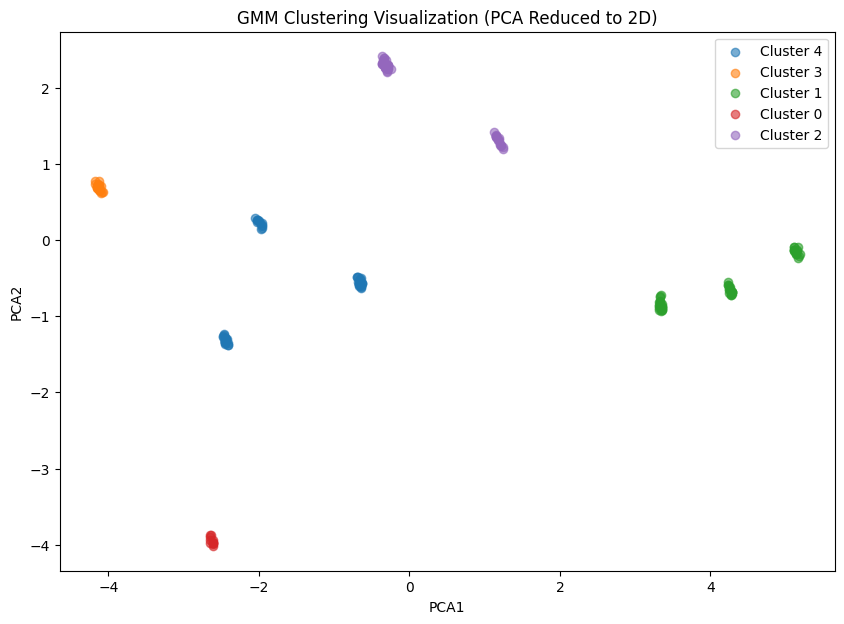

In [183]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_features_df.iloc[:, :-1])

scaled_features_df["PCA1"] = pca_data[:, 0]
scaled_features_df["PCA2"] = pca_data[:, 1]

plt.figure(figsize=(10, 7))
for cluster_id in scaled_features_df["GMM_Cluster"].unique():
    cluster_data = scaled_features_df[scaled_features_df["GMM_Cluster"] == cluster_id]
    plt.scatter(cluster_data["PCA1"], cluster_data["PCA2"], label=f"Cluster {cluster_id}", alpha=0.6)

plt.title("GMM Clustering Visualization")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.show()

### Performance of GMM Clustering:

- Number of Clusters: 5
- K-Means Clustering - Davies-Bouldin(DB) Index: 0.469
- K-Means Clustering - Silhouette Score: 0.682

## K Means Clustering
K-Means clustering is efficient for large datasets and works well when the data has distinct clusters. It simplifies segmentation by assigning each customer to the nearest cluster centroid, making it easy to interpret. For customer data, where clear groupings based on activity, spending, or preferences are expected, K-Means provides quick and effective results

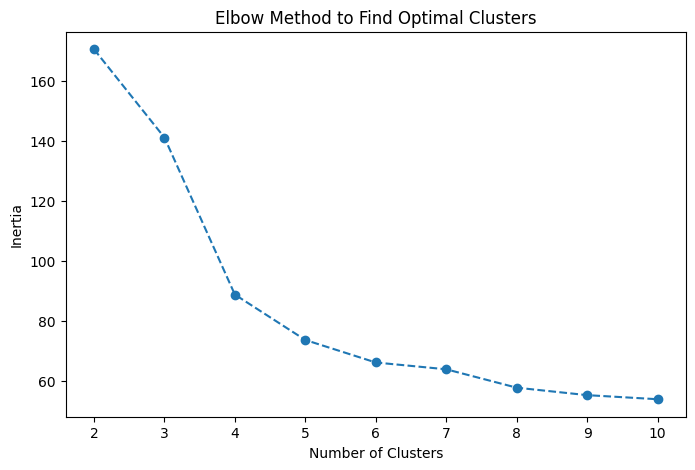

Number of Clusters: 4
K-Means Clustering - Davies-Bouldin Index: 0.6184524088035867
K-Means Clustering - Silhouette Score: 0.5994729925962893


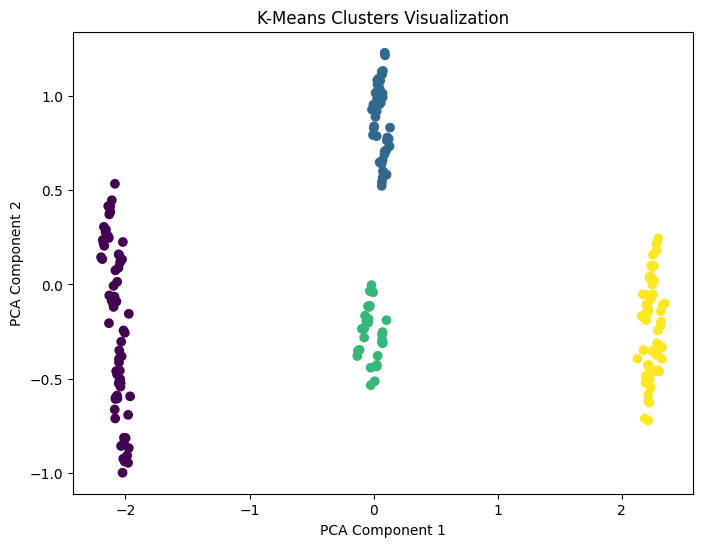

In [176]:
scaled_features = scaled_features_df


inertia = []
range_n_clusters = range(2, 11)
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method to Find Optimal Clusters')
plt.show()

optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)

scaled_features_df["KMeans_Cluster"] = kmeans_labels


kmeans_db_index = davies_bouldin_score(scaled_features, scaled_features_df["KMeans_Cluster"])
kmeans_silhouette = silhouette_score(scaled_features, scaled_features_df["KMeans_Cluster"])

print(f"Number of Clusters: {optimal_clusters}")
print(f"K-Means Clustering - Davies-Bouldin Index: {kmeans_db_index}")
print(f"K-Means Clustering - Silhouette Score: {kmeans_silhouette}")


pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=scaled_features_df["KMeans_Cluster"])
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clusters Visualization')
plt.show()


### Elbow Chart Signifigance:

The elbow chart helps determine the optimal number of clusters in clustering algorithms like K-Means. It plots the inertia (within-cluster sum of squared distances) against the number of clusters. As the number of clusters increases, the inertia decreases, but the rate of improvement diminishes. The "elbow point" marks the optimal number of clusters, where adding more clusters provides marginal improvement

### Performance of K Means:

- Number of Clusters: 4
- K-Means Clustering - Davies-Bouldin(DB) Index: 0.618
- K-Means Clustering - Silhouette Score: 0.599

## Some Analysis & Observation on Clustering Performance

### Pairplot analysis of various features used in Clustering and their analysis

#### Some Oberservations:

- Clusters appear well-separated based on `Region_Encoded`, indicating that region strongly influences customer segmentation.

- overlap between clusters when comparing `SignupDays` to other features like `total_transactions` and `avg_transaction_value`indicating that signup time alone may not significantly differentiate clusters.

- `avg_transaction_value` vs. `total_transactions`:
Clusters exhibit some overlap but show distinct patterns in how **high-transaction customers** behave compared to **low-transaction ones.**

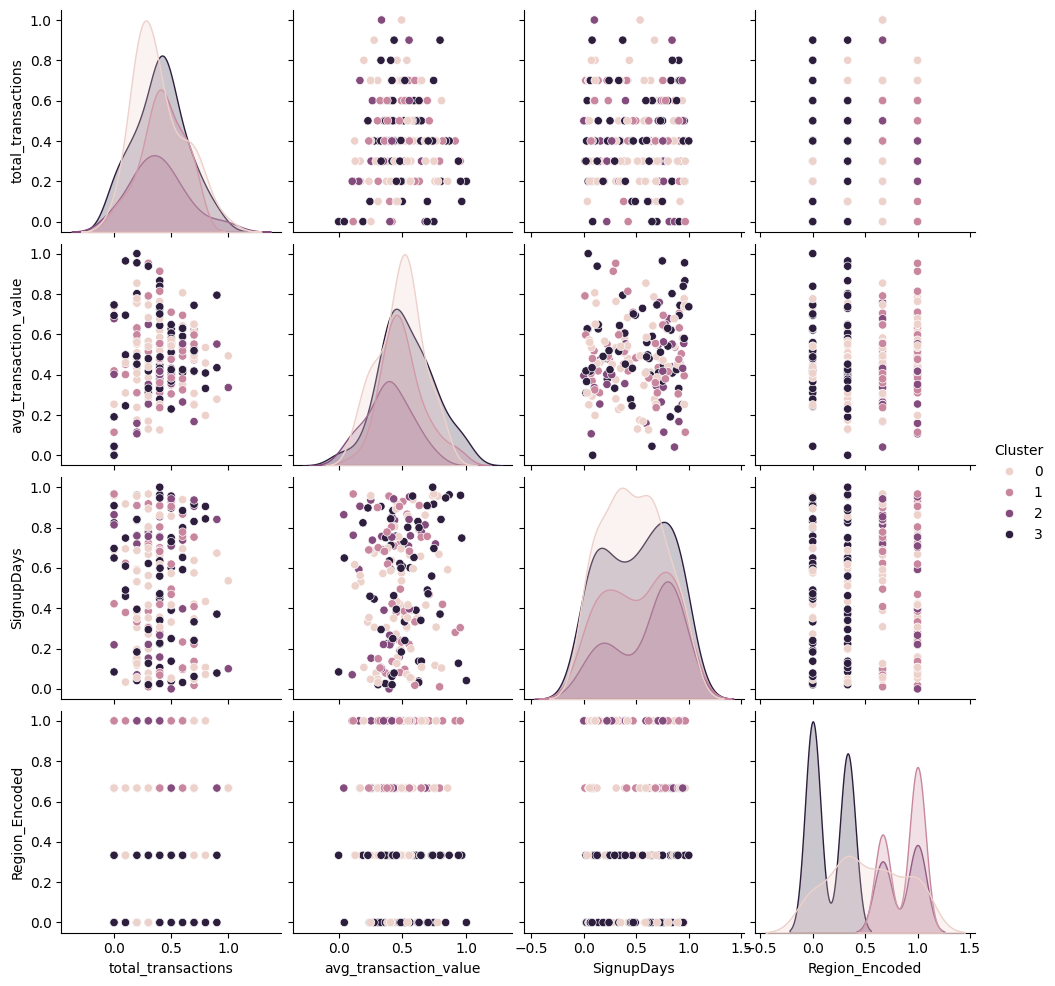

In [177]:

scaled_features_df['Cluster'] = kmeans_labels
sns.pairplot(scaled_features_df, hue='Cluster', vars=['total_transactions', 'avg_transaction_value', 'SignupDays', 'Region_Encoded'])
plt.show()


### Correlation Matrix

This correlation matrix provides important insights into the relationships between features and how well clustering results align with them

#### Some Oberservations:

- `total_transactions` and `avg_transaction_value`:
Very low correlation (~0.02), indicating that transaction frequency and value are independent, which is useful for segmenting customers based on behavior.

- `Region_Encoded` and `MostBoughtCategory_Encoded`:
Low correlation (~0.03), suggesting that region does not strongly influence the most bought category, but segmentation based on both features may still be valuable.

- `GMM_Cluster` and `MostBoughtCategory_Encoded`:
High correlation (~0.74), showing that GMM clustering effectively captures category preferences.

- `KMeans_Cluster` and `MostBoughtCategory_Encoded`:
Moderate correlation (~0.54), meaning K-Means clustering is less effective than GMM at capturing category preferences.

- `SignupDays`:
Weak correlations with all other features, implying that customer tenure may not significantly influence segmentation.

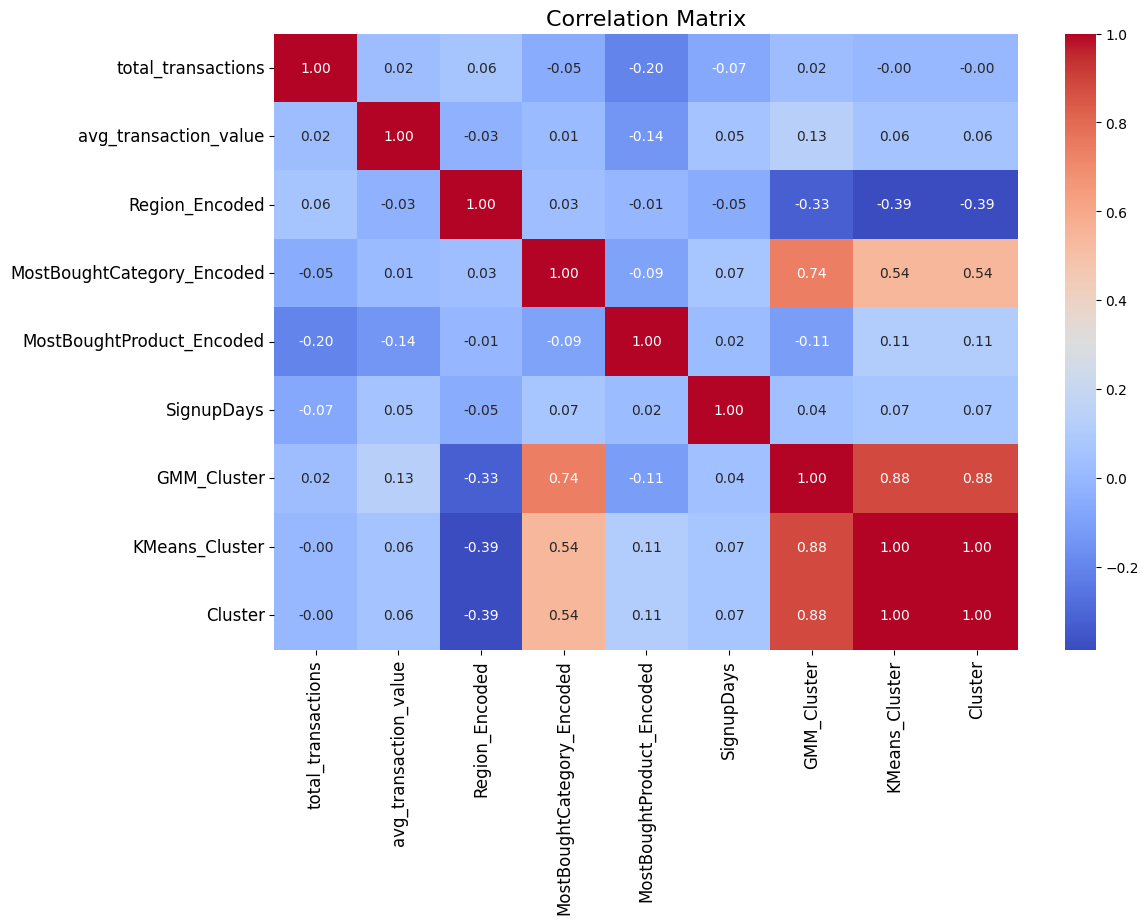

In [179]:

filtered_features = scaled_features_df.drop(columns=['PCA1', 'PCA2'], errors='ignore')

correlation_matrix = filtered_features.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title("Correlation Matrix", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
